In [1]:
# импортируем Pandas
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# подключимся к данным по тренировкам
workouts = pd.read_csv('workouts.csv', parse_dates=['start_at']) 

# подключимся к данным по пользователям
users = pd.read_excel('users.xlsx')

# подключимся к данным по оплатам
payments = pd.read_excel('payments.xlsx') 

# подключимся к данным маркетинга
marketing = pd.read_excel('marketing.xlsx') 

In [3]:
# переводим даты в нужный формат
payments['payment_datetime'] = pd.to_datetime(payments.payment_date) 

# объединим платежи и данные о географии студентов
payments_with_geo = pd.merge(payments, 
                             users[['user_id','geo_group']], 
                             on='user_id') 
payments_with_geo.head()

,user_id,payment_id,workout_type,amount,payment_date,payment_datetime,geo_group
0,132815,1535249,general,10337.768848,2020-01-30 15:03:59,2020-01-30 15:03:59,Регионы РФ
1,165987,2395447,general,9711.925350,2020-08-18 21:59:09,2020-08-18 21:59:09,СНГ
2,165987,2226467,general,9216.755623,2020-07-08 19:34:29,2020-07-08 19:34:29,СНГ
3,165987,2710743,general,9811.925350,2020-10-26 20:32:55,2020-10-26 20:32:55,СНГ
4,165987,2844567,general,9811.925350,2020-11-24 09:37:00,2020-11-24 09:37:00,СНГ


In [20]:
# вычисляем даты первых оплат для каждого клиента
fst_payment = payments_with_geo.groupby(['user_id', 'geo_group'])['payment_date'].min() 

# сбрасываем индекс
fst_payment = fst_payment.reset_index() 

# считаем количество первых оплат в каждом месяце и гео-группе
fst_payment_month = fst_payment.groupby([fst_payment['payment_date'].dt.month,
                                         fst_payment['geo_group']])['user_id'].count().reset_index() 

fst_payment_month.head()

,payment_date,geo_group,user_id
0,1,Без страны,2
1,1,Москва,194
2,1,Регионы РФ,169
3,1,СНГ,58
4,2,Москва,207


In [5]:
# переименовали с помощью метода .columns
fst_payment_month.columns = ['month', 'geo_group', 'sales'] 

# объединим первые оплаты с данными о затратах на маркетинг
marketing_sales = pd.merge(fst_payment_month, 
                           marketing, 
                           on=['geo_group','month'])
# найдём общее количество привлеченных клиентов и сумму затрат на маркетинг
marketing_sales_total = marketing_sales.groupby('month')[['sales','budget']].sum().reset_index()

marketing_sales_total.head()

,month,sales,budget
0,1,421,1.363459e+06
1,2,490,1.985795e+06
2,3,488,1.990748e+06
3,4,698,4.308354e+06
4,5,432,1.499338e+06


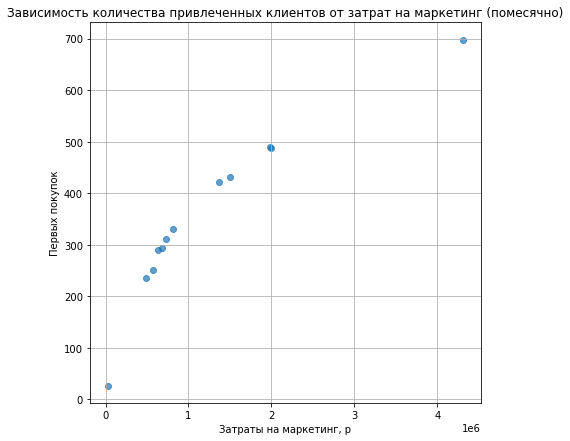

In [6]:
# построим график
plt.figure(figsize=(7, 7))  

# подпишем оси и название 
plt.title('Зависимость количества привлеченных клиентов от затрат на маркетинг (помесячно)') 
plt.xlabel('Затраты на маркетинг, р') 
plt.ylabel('Первых покупок') 

plt.grid()  # включим сетку

# передали 3 аргумента
plt.scatter(
        marketing_sales_total['budget'], 
        marketing_sales_total['sales'], 
        alpha = 0.7  # прозрачность точек
)

plt.show() 

Посмотрим, как выглядят наши затраты на маркетинг в разных гео-группах

In [7]:
# посмотрим какие уникальные geo_group существуют
geo_groups = set(marketing_sales['geo_group'])
geo_groups

{'Москва', 'Регионы РФ', 'СНГ'}

In [8]:
# зададим цвет для каждой группы

colors = {'Москва':'c', 
          'Регионы РФ':'tab:olive', 
          'СНГ':'r', 
          'Без страны':'k'} 
# передадим в качестве аргумента 
marketing_sales['geo_group'].map(colors).head(10)

0            c
1    tab:olive
2            r
3            c
4    tab:olive
5            r
6            c
7    tab:olive
8            r
9            c
Name: geo_group, dtype: object

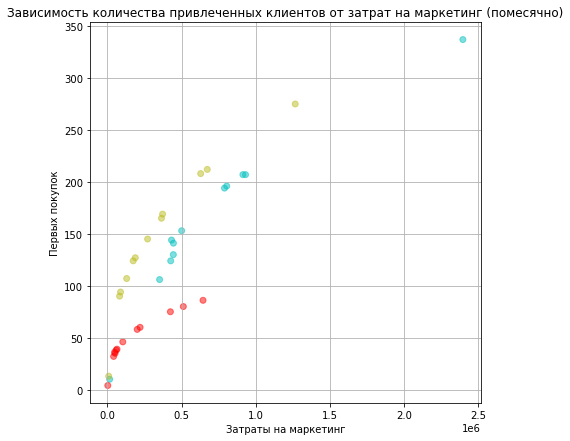

In [9]:
plt.figure(figsize=(7, 7))  # зададим размер фигуры

# названия осей и графика
plt.title('Зависимость количества привлеченных клиентов от затрат на маркетинг (помесячно)') 
plt.xlabel('Затраты на маркетинг') 
plt.ylabel('Первых покупок') 
plt.grid() # сетка

scatter = plt.scatter(
    marketing_sales.budget, # ось OX 
    marketing_sales.sales, # ось OY
    
    c = marketing_sales['geo_group'].map(colors),  # задаем цвета точек как четвертое измерение
    alpha = 0.5 # прозрачность 50%
)
plt.show()

### Задача

Мы хотим исследовать динамику общего количества тренировок в течение года по неделям.

In [10]:
# записываем новый датасет с количеством тренировок по неделям
workouts_byweek = workouts.resample('W', on='start_at')['workout_id'].count() 

#выведем первые 10 элементов
workouts_byweek.head(10)

start_at
2020-01-05      24
2020-01-12     122
2020-01-19     270
2020-01-26     427
2020-02-02     571
2020-02-09     795
2020-02-16     959
2020-02-23    1075
2020-03-01    1241
2020-03-08    1339
Freq: W-SUN, Name: workout_id, dtype: int64

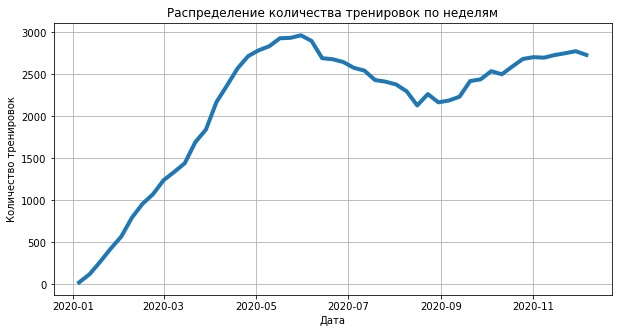

In [11]:
plt.figure(figsize=(10, 5)) # размеры графика
# названия и подписи
plt.title('Распределение количества тренировок по неделям') 
plt.xlabel('Дата') 
plt.ylabel('Количество тренировок') 
plt.grid() # сетка
# с помощью iloc срезали "хвост"
plt.plot(workouts_byweek.iloc[:-1],linewidth=4) #количество тренировок в каждую неделю 
plt.show()

### Задача

Мы хотим исследовать динамику общего количества тренировок в течение года по неделям.

In [12]:
# отбираем только интересующие нас тренировки
client_week_workouts = workouts[(workouts.status=='success')&
                                (workouts.workout_schedule_type!='trial')]
# для группировки по id и неделям заранее вытащим нужные данные
client_id = workouts['client_id']
weeks = workouts['start_at'].dt.week
# посчитаем кол-во тренировок
client_week_workouts = client_week_workouts.groupby([client_id, weeks])['workout_id'].count().reset_index()
client_week_workouts.head(10)

C:\Users\josep\AppData\Local\Temp\ipykernel_12532\1438559351.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  weeks = workouts['start_at'].dt.week


,client_id,start_at,workout_id
0,185,15,3
1,185,18,2
2,185,19,1
3,185,20,1
4,185,21,2
5,185,22,1
6,185,23,2
7,185,25,1
8,185,26,1
9,185,30,1


In [13]:
# среднее кол-во тренировок в неделю
avg_workouts_per_week = client_week_workouts.groupby('client_id')['workout_id'].mean()
avg_workouts_per_week

client_id
185        1.480000
1455       1.777778
1558       1.333333
5312       1.000000
5804       1.200000
             ...   
5460246    1.595238
5468992    1.833333
5477981    1.375000
5498391    1.333333
5511356    1.333333
Name: workout_id, Length: 4238, dtype: float64

**Строим график**

Построим гистограмму с помощью функции `hist()`, которая на вход принимает: 

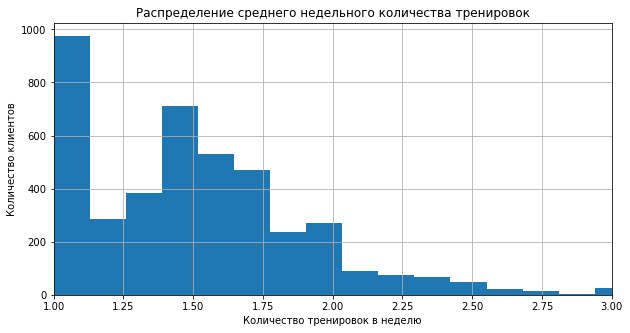

In [14]:
plt.figure(figsize=(10, 5)) # размерность
plt.title('Распределение среднего недельного количества тренировок') 
plt.xlabel('Количество тренировок в неделю') 
plt.ylabel('Количество клиентов')

plt.xlim((1, 3)) #отрежем выбросы

plt.grid() # сетка

#отрисовываем гистограмму
plt.hist(avg_workouts_per_week, bins=50) #50 - количество бинов

plt.show()

In [15]:
revenue_byday_month = payments.groupby([payments['payment_date'].dt.day,
                                        payments['payment_date'].dt.month])['amount'].sum()

revenue_byday_month.index.names = ['day','month'] # переименовали шапку
revenue_byday_month = revenue_byday_month.reset_index() #сбросили индекс
revenue_byday_month.head()

,day,month,amount
0,1,2,178773.732704
1,1,3,163031.504867
2,1,4,426633.406696
3,1,5,335634.608333
4,1,6,486702.074736


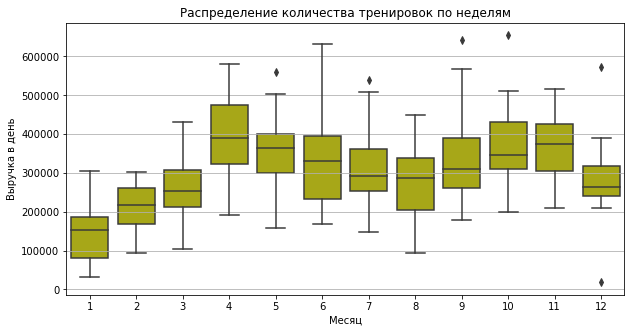

In [16]:
plt.figure(figsize=(10, 5))  # зададим размер фигуры
plt.title('Распределение количества тренировок по неделям') # подпишем заголовок графика
plt.grid() # Добавим сетку
#отрисовываем график
sns.boxplot(x='month',
            y='amount',
            data=revenue_byday_month, 
            color='y')
plt.ylabel('Выручка в день') # Подпишем ось Y
plt.xlabel('Месяц') # Подпишем ось Y
plt.show()

### Задача 

Определить самые загруженные часы в течении недели

In [17]:
workouts['hour'] =  workouts['start_at'].dt.hour
workouts['dayofweek'] = workouts['start_at'].dt.dayofweek

# cгруппируем датасорс по часу и дню недели и посчитаем количество тренировок 
workouts_hourday = workouts.groupby(['hour', 'dayofweek']).workout_id.count()
workouts_hourday = workouts_hourday.reset_index() # убираем колонки группировки из индекса

# посмотрим на таблицу
workouts_hourday.head()

,hour,dayofweek,workout_id
0,0,0,1
1,0,1,8
2,0,2,12
3,0,3,2
4,0,4,5


In [18]:
# воспользуемся функцией pivot, чтобы создать сводную таблицу (нужно для создания heatmap)
heat_weekdhour = workouts_hourday.pivot(index="dayofweek", 
                                        columns="hour", 
                                        values="workout_id")
# заменим NA значения на 0
heat_weekdhour.fillna(0, inplace=True)
# переопределим значения дня недели
heat_weekdhour.index = [
    'Понедельник',
    'Вторник',
    'Среда',
    'Четверг',
    'Пятница',
    'Суббота',
    'Воскресение']
heat_weekdhour # посмотрим что получилось

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Понедельник,1.0,3.0,1.0,0.0,17.0,26.0,142.0,369.0,602.0,1281.0,...,746.0,808.0,980.0,1187.0,1652.0,1961.0,1586.0,1199.0,391.0,77.0
Вторник,8.0,8.0,19.0,9.0,2.0,38.0,132.0,278.0,493.0,1075.0,...,723.0,639.0,898.0,1238.0,1324.0,1956.0,1715.0,1323.0,544.0,74.0
Среда,12.0,2.0,2.0,0.0,4.0,15.0,108.0,261.0,639.0,1059.0,...,701.0,700.0,801.0,1226.0,1519.0,1799.0,1480.0,1019.0,360.0,60.0
Четверг,2.0,1.0,1.0,3.0,14.0,18.0,138.0,189.0,505.0,1271.0,...,722.0,802.0,809.0,1185.0,1592.0,2188.0,1719.0,1101.0,499.0,141.0
Пятница,5.0,7.0,18.0,0.0,1.0,30.0,120.0,260.0,647.0,1228.0,...,855.0,817.0,884.0,1100.0,1100.0,1221.0,963.0,743.0,220.0,21.0
Суббота,7.0,6.0,2.0,0.0,3.0,11.0,45.0,136.0,345.0,821.0,...,847.0,618.0,600.0,532.0,419.0,386.0,384.0,251.0,92.0,21.0
Воскресение,7.0,8.0,1.0,2.0,1.0,5.0,15.0,59.0,226.0,639.0,...,777.0,609.0,432.0,472.0,382.0,563.0,433.0,430.0,115.0,13.0


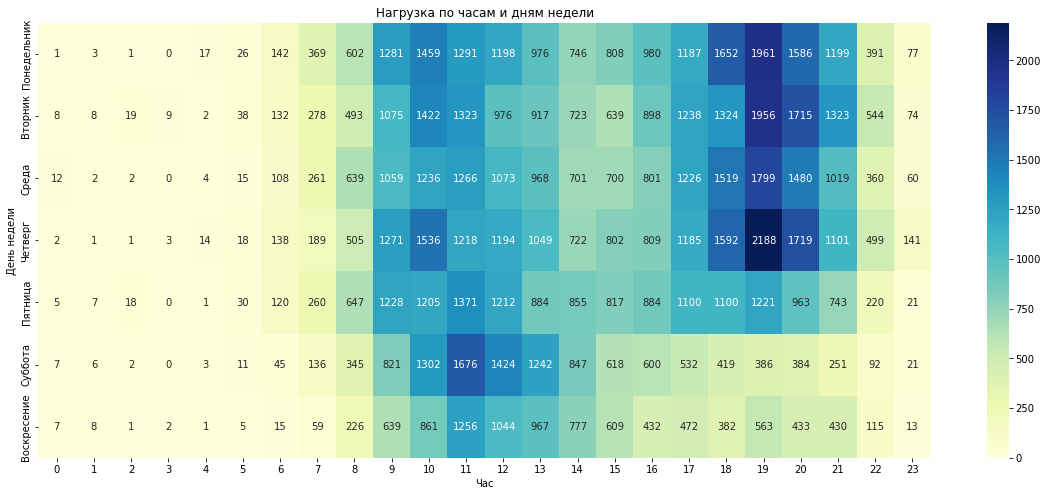

In [19]:
plt.figure(figsize=(20,8))
sns.heatmap(heat_weekdhour, 
            annot = True, # в ячейках значения
            cmap = "YlGnBu", #цветовая карта
            fmt = 'g') # формат чисел без запятой
plt.title("Нагрузка по часам и дням недели")
plt.ylabel("День недели")
plt.xlabel("Час")
plt.show()